# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction

In [3]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

%matplotlib inline

### I next want to get a list of all of my functional files

In [10]:
sid = ['021']
base_dir = '/home/csted001/Mattfeld_PSB6351'
work_dir = '/scratch/classroom/psb6351/csted001/option2'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-1/func')
fmap_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-1/fmap')
#fs_dir = os.path.join(base_dir, 'derivatives', 'freesurfer')

# Get a list of my study task json and nifti converted files
func_json = sorted(glob(func_dir + '/*.json'))
func_files = sorted(glob(func_dir + '/*.nii.gz'))
fmap_files = sorted(glob(fmap_dir + '/*func*.nii.gz'))

### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [18]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
extractref.inputs.in_file = func_files[0]
#extractref.inputs.t_min = int(np.ceil(nb.load(study_func_files[0]).shape[3]/2)) #PICKING MIDDLE
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')



# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter')
tshifter.inputs.tr = '1.76'
tshifter.inputs.slice_timing = slice_timing_list
tshifter.inputs.outputtype = 'NIFTI_GZ'
tshifter.inputs.in_file = func_files



# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.
volreg = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg')
volreg.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(tshifter, "out_file", volreg, 'in_file')
psb6351_wf.connect(extractref, 'roi_file', volreg, 'basefile')




#for slce timing first, then motion
# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproctwo')
datasink.inputs.container = f'sub-{sid[0]}'
psb6351_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(volreg, 'out_file', datasink, 'motion.@corrfile')
psb6351_wf.connect(volreg, 'oned_matrix_save', datasink, 'motion.@matrix')
psb6351_wf.connect(volreg, 'oned_file', datasink, 'motion.@par')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions')

# The following two lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.run(plugin='SLURM',
               plugin_args={'sbatch_args': ('--partition classroom --qos pq_psb6351 --account acc_psb6351'),
                            'overwrite':True})

221007-15:52:57,946 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
221007-15:52:58,123 nipype.workflow INFO:
	 Running in parallel.
221007-15:52:58,172 nipype.workflow INFO:
	 Pending[0] Submitting[3] jobs Slots[inf]
221007-15:52:58,180 nipype.workflow INFO:
	 Submitting: psb6351_wf.id_outliers ID: 0
221007-15:52:58,190 nipype.workflow INFO:
	 [Job 0] Cached (psb6351_wf.id_outliers).
221007-15:52:58,196 nipype.workflow INFO:
	 Finished submitting: psb6351_wf.id_outliers ID: 0
221007-15:52:58,248 nipype.workflow INFO:
	 Submitting: psb6351_wf.getsubs ID: 2
221007-15:52:58,274 nipype.workflow INFO:
	 [Job 2] Cached (psb6351_wf.getsubs).
221007-15:52:58,290 nipype.workflow INFO:
	 Finished submitting: psb6351_wf.getsubs ID: 2
221007-15:52:58,301 nipype.workflow INFO:
	 Pending[0] Submitting[7] jobs Slots[inf]
221007-15:52:58,307 nipype.workflow INFO:
	 Submitting: psb6351_wf.getbestvol ID: 3
221007-15:52:58,418 nipype.workflow INFO:
	

In [6]:
func_files

['/home/csted001/Mattfeld_PSB6351/dset/sub-021/ses-1/func/sub-021_loc_run-1_bold.nii.gz',
 '/home/csted001/Mattfeld_PSB6351/dset/sub-021/ses-1/func/sub-021_loc_run-2_bold.nii.gz',
 '/home/csted001/Mattfeld_PSB6351/dset/sub-021/ses-1/func/sub-021_task-study_run-1_bold.nii.gz',
 '/home/csted001/Mattfeld_PSB6351/dset/sub-021/ses-1/func/sub-021_task-study_run-2_bold.nii.gz',
 '/home/csted001/Mattfeld_PSB6351/dset/sub-021/ses-1/func/sub-021_task-study_run-3_bold.nii.gz',
 '/home/csted001/Mattfeld_PSB6351/dset/sub-021/ses-1/func/sub-021_task-study_run-4_bold.nii.gz']

### Now I will load and plot the motion files

/tmp/ipykernel_23071/2202331576.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


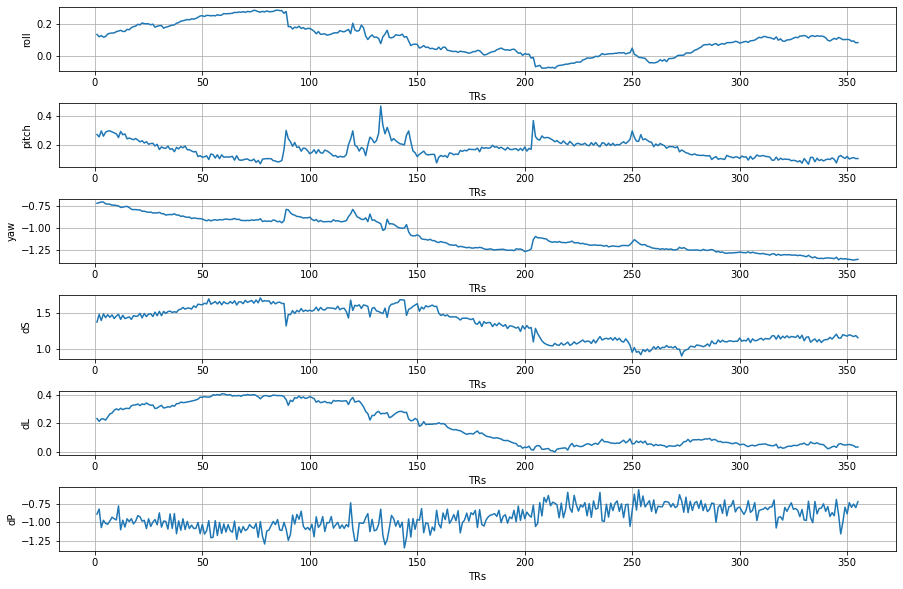

/tmp/ipykernel_23071/2202331576.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


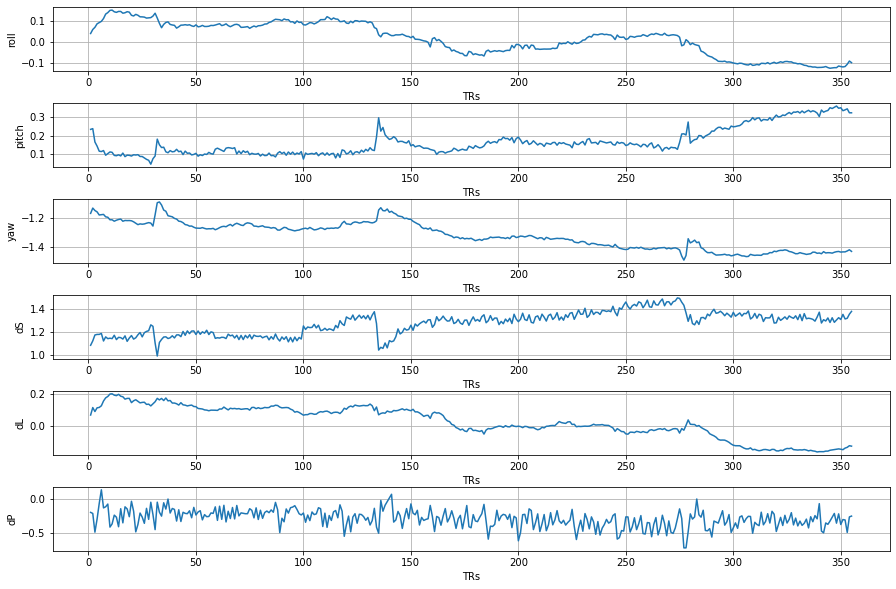

/tmp/ipykernel_23071/2202331576.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


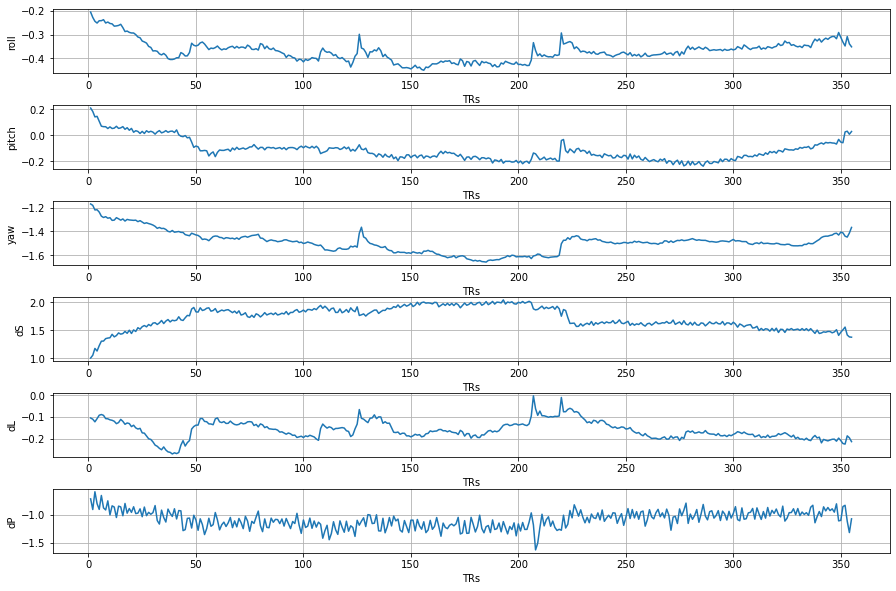

/tmp/ipykernel_23071/2202331576.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


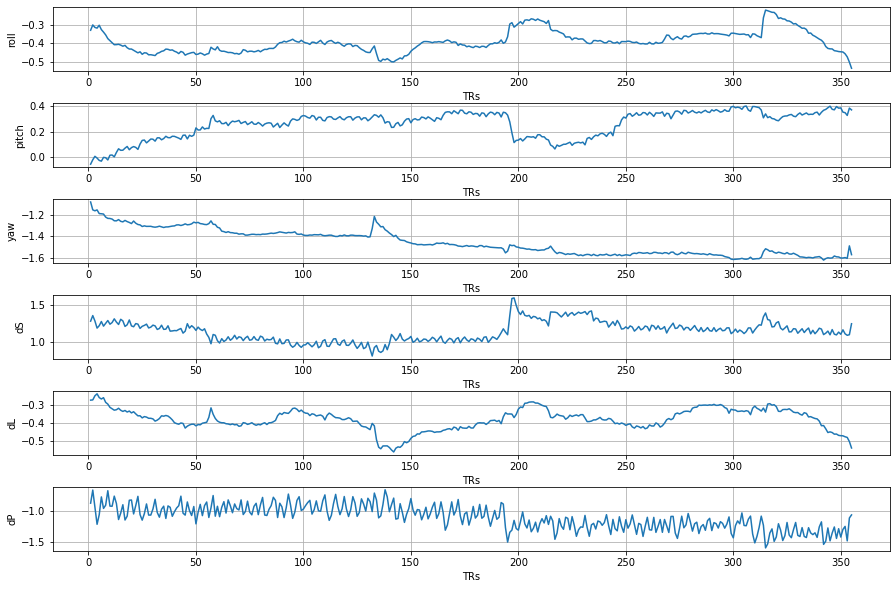

In [7]:
##motion correction first, then slice timing

motion_dir = os.path.join(base_dir, f'derivatives/preproc/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*study*_bold.1D'))

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']

    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()

In [9]:
study_motcorr_files = sorted(glob(motion_dir + '/*.nii.gz'))
study_motcorr_img_data = nb.load(study_motcorr_files[0]).get_fdata()
study_orig_img_data = nb.load(func_files[0]).get_fdata()

#test_motcorr_img_data.shape

print(study_motcorr_img_data[50,50,32,50])
print(study_orig_img_data[50,50,32,50])

135.0
135.0


/tmp/ipykernel_23071/24474429.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df_slicefirst = pd.read_csv(curr_mot_file, sep="  ", header=None)


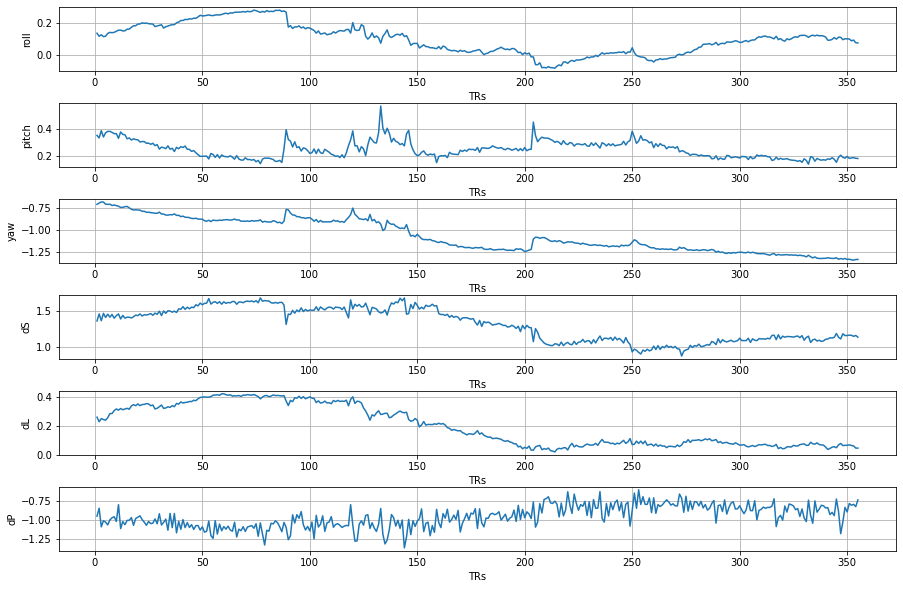

/tmp/ipykernel_23071/24474429.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df_slicefirst = pd.read_csv(curr_mot_file, sep="  ", header=None)


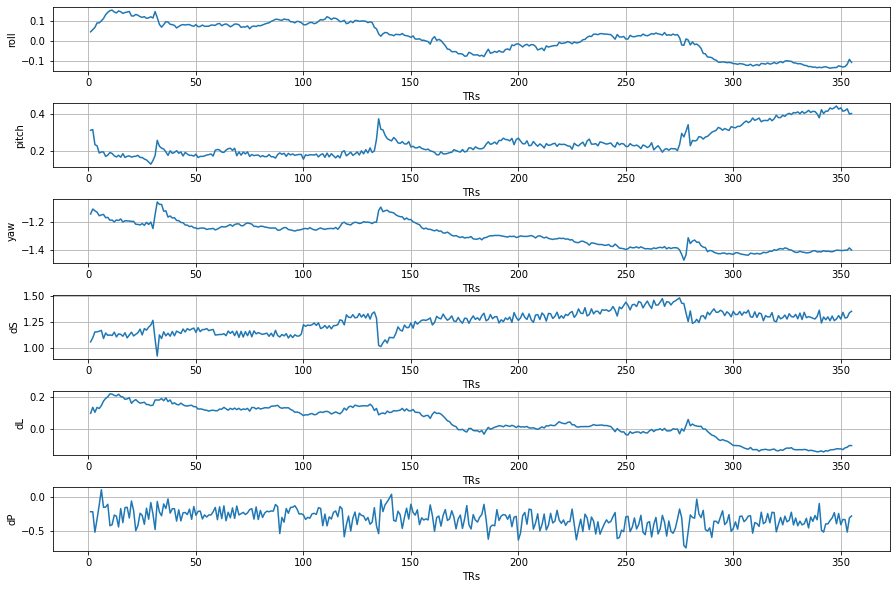

/tmp/ipykernel_23071/24474429.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df_slicefirst = pd.read_csv(curr_mot_file, sep="  ", header=None)


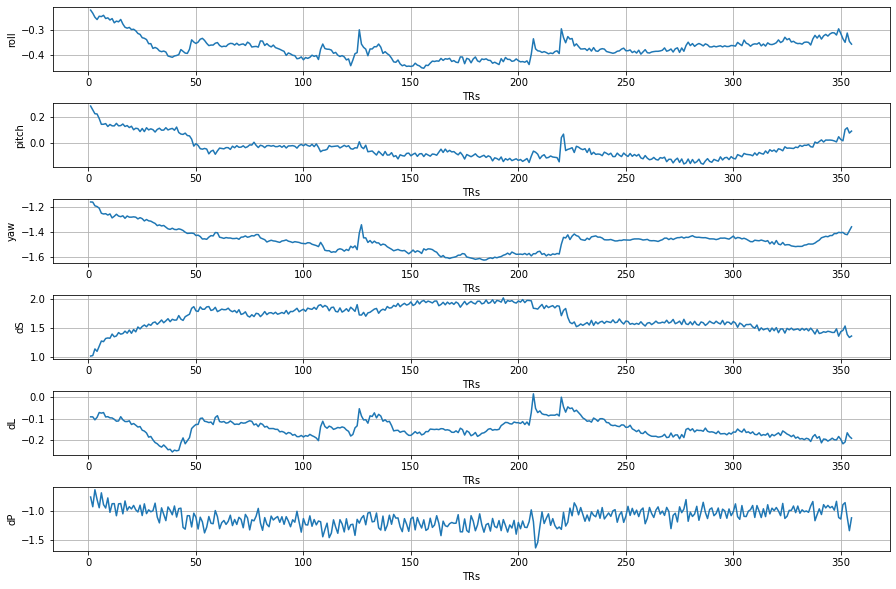

/tmp/ipykernel_23071/24474429.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df_slicefirst = pd.read_csv(curr_mot_file, sep="  ", header=None)


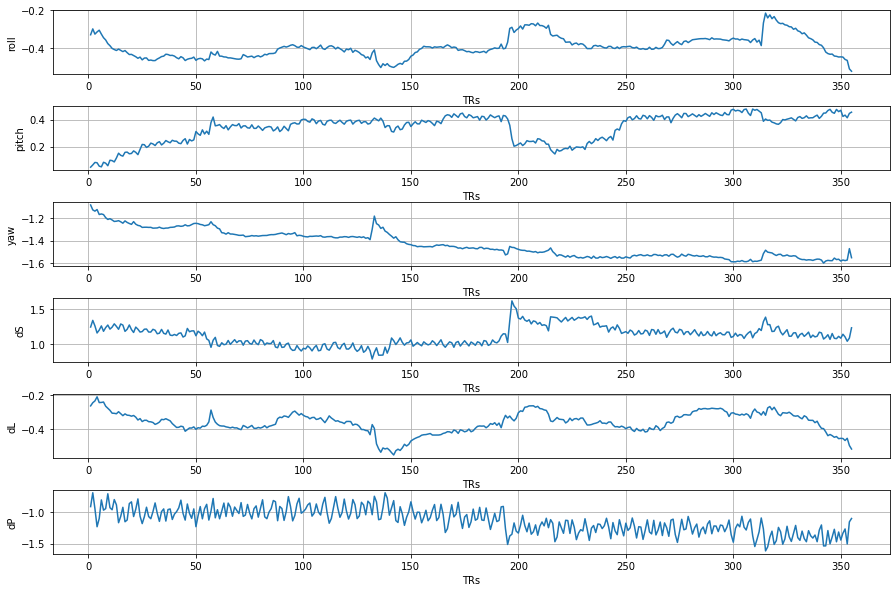

In [33]:
#slice timing 1st, then motion correction
#why isn't it working now that I've added tshift??

motion_dir_slicefirst = os.path.join(base_dir, f'derivatives/preproctwo/sub-{sid[0]}/motion')
study_motion_files_slicefirst = sorted(glob(motion_dir_slicefirst + '/*study*_bold_tshift.1D'))

for curr_mot_file in study_motion_files_slicefirst:
    motion_df_slicefirst = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df_slicefirst.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']

    num_vols_slicefirst = range(1, len(motion_df_slicefirst)+1)
    fig, axs_slicefirst = plt.subplots(motion_df_slicefirst.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df_slicefirst.keys()):
        axs_slicefirst[idx].plot(num_vols_slicefirst, motion_df_slicefirst[f'{curr_col}'])
        axs_slicefirst[idx].set_xlabel('TRs')
        axs_slicefirst[idx].set_ylabel(f'{curr_col}')
        axs_slicefirst[idx].grid(True)

    plt.show()

In [28]:
motion_dir_slicefirst

'/home/csted001/Mattfeld_PSB6351/derivatives/preproctwo/sub-021/motion'

In [29]:
study_motion_files_slicefirst

['/home/csted001/Mattfeld_PSB6351/derivatives/preproctwo/sub-021/motion/sub-021_task-study_run-1_bold_tshift.1D',
 '/home/csted001/Mattfeld_PSB6351/derivatives/preproctwo/sub-021/motion/sub-021_task-study_run-2_bold_tshift.1D',
 '/home/csted001/Mattfeld_PSB6351/derivatives/preproctwo/sub-021/motion/sub-021_task-study_run-3_bold_tshift.1D',
 '/home/csted001/Mattfeld_PSB6351/derivatives/preproctwo/sub-021/motion/sub-021_task-study_run-4_bold_tshift.1D']